Imports

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from os.path import join
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy as sp
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import timeit


save_dir = 'saved_models/'
path = 'dog-breed-identification/'

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

Task 1 - Meta info on the data set

Size of train data: 10222
Size of test data: 10357
number_of_classes: 120
number_of_dimentions: (10222, 2)
                                 id
breed                              
affenpinscher                    80
afghan_hound                    116
african_hunting_dog              86
airedale                        107
american_staffordshire_terrier   74
...                             ...
welsh_springer_spaniel           79
west_highland_white_terrier      81
whippet                          95
wire-haired_fox_terrier          82
yorkshire_terrier                82

[120 rows x 1 columns]
85.18333333333334
13.242597512908445
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64


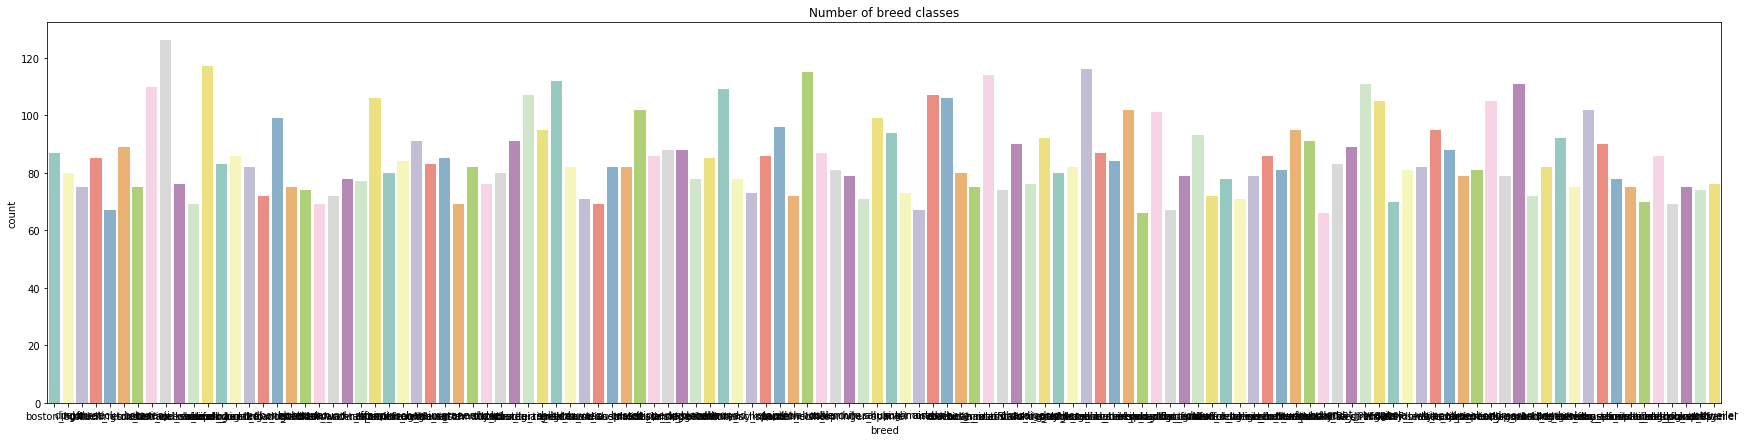

In [4]:
def read_data(path):
    filelist_train = glob.glob(path + 'train' + '*/*.jpg')
    filelist_test = glob.glob(path + 'test' + '*/*.jpg')
    print("Size of train data: {}".format(len(filelist_train)))
    print("Size of test data: {}".format(len(filelist_test)))
    df_labels = pd.read_csv(path + 'labels.csv')
    
    classes = df_labels.breed.unique()
    print("number_of_classes: {}".format(len(classes)))
    print("number_of_dimentions: {}".format(df_labels.shape))
    print(df_labels.groupby(['breed']).count())
    classes_arr = np.sort(df_labels.groupby(['breed']).count())
    classes_arrr= []
    for i in classes_arr:
        classes_arrr.append(i[0])
    classes_arrr = np.sort(classes_arrr)
    print(np.mean(classes_arrr))
    print(np.std(classes_arrr))
          
read_data(path)
          
def class_dist():         
    labels_all = pd.read_csv(path+"labels.csv")
    # Visualize the number of each breeds
    breeds_all = labels_all["breed"]
    plt.figure(figsize=(30,7))
    g = sns.countplot(breeds_all, palette="Set3")
    plt.title("Number of breed classes")
    breed_counts = breeds_all.value_counts()
    print(breed_counts)
class_dist()

Task 2

Reading train data

In [5]:
df_train = pd.read_csv(path + 'labels.csv')
filename = []
for file in df_train['id']:
    filename.append(str(file) + '.jpg')
df_train['id'] = filename
Y = df_train['breed']

Plot function

In [6]:
def plot_model(model_hist):
        acc = model_hist.history['accuracy']
        val_acc = model_hist.history['val_accuracy']
        loss = model_hist.history['loss']
        val_loss = model_hist.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(15, 6));
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, color='#0984e3', marker='o', linestyle='none', label='Training Accuracy')
        plt.plot(epochs, val_acc, color='#0984e3', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, color='#eb4d4b', marker='o', linestyle='none', label='Training Loss')
        plt.plot(epochs, val_loss, color='#eb4d4b', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.show()


Data Generators

In [7]:
datagen1 = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range = 20,  # randomly rotate images
        zoom_range = 0.2, # Randomly zoom images
        width_shift_range = 0.25,  # randomly shift images horizontally
        height_shift_range = 0.25,  # randomly shift images vertically
        horizontal_flip = True,  # randomly flip images horizontally
        vertical_flip = True,
        fill_mode="nearest",
        shear_range=0.2)  # randomly flip images vertically



valgen = ImageDataGenerator(rescale=1.0 / 255) 

Model defenition

In [8]:
def get_base_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu' , input_shape=(100,100,3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))#
    model.add(Flatten())
    model.add(Dense(300))
    model.add(Dense(300))
    model.add(Dense(120, activation='softmax'))
    return model

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

define callbacks

In [9]:
def set_callbacks(description='run1',patience=5,tb_base_logdir='.\\logs\\'):
    cp = ModelCheckpoint(save_dir+'best_model_weights_{}.h5'.format(description),save_best_only=True, monitor='val_accuracy',save_weights_only=False, mode='max')
    es = EarlyStopping(patience=patience,monitor='val_loss')   
    log = CSVLogger('csv_logs\\{}\\train_log.csv'.format(description))
    tb = TensorBoard(log_dir='{}{}'.format(tb_base_logdir,description))
    cb = [cp,es,log,tb]
    return cb

def save_model(model,filename):
    # this is a helper function used to save a tensorflow.keras NN model architecture and weights
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(filename+'_architecture.json', 'w').write(json_string)
    model.save_weights(filename+'_model_weights.h5', overwrite=True)
    print("Model Saved Succsesfully")

KFold, compiling and fitting

In [ ]:
kf = KFold(n_splits = 5)
fold_var = 1
image_dir = path + 'train/'

history=0

for train_index,val_index in kf.split(np.zeros(len(Y)),Y):
    train_data = df_train.iloc[train_index]
    val_data = df_train.iloc[val_index]

   
    model=get_base_model()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()

    if fold_var<=1:
      model.load_weights('important weights/improved model/best_model_weights_{}.h5'.format(4)) 
    else:
       model.load_weights(save_dir+'best_model_weights_{}.h5'.format(fold_var-1)) 

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_var} ...')
    
    train_data_generator = datagen.flow_from_dataframe(train_data, directory = image_dir, x_col = "id", y_col = "breed",target_size=(100, 100),
    batch_size=32,color_mode="rgb",class_mode = "categorical", shuffle = True)
    valid_data_generator = valgen.flow_from_dataframe(val_data, directory = image_dir, x_col = "id", y_col = "breed",target_size=(100,100),
    batch_size=32,color_mode="rgb",class_mode = "categorical", shuffle = True)
    
    callbacks_list = set_callbacks(description=fold_var)
    history = model.fit(train_data_generator, epochs=300, callbacks= callbacks_list, validation_data=valid_data_generator)
    plot_model(history)


    model.load_weights(save_dir+'best_model_weights_{}.h5'.format(fold_var))
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    tf.keras.backend.clear_session()
    
    fold_var += 1

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(VALIDATION_ACCURACY)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {VALIDATION_LOSS[i]} - Accuracy: {VALIDATION_ACCURACY[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(VALIDATION_ACCURACY)} (+- {np.std(VALIDATION_ACCURACY)})')
print(f'> Loss: {np.mean(VALIDATION_LOSS)}')
print('------------------------------------------------------------------------')
filepath = '.\\saved_model'
save_model(model, filepath)

Read img to RAM

In [13]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string, name of the file
        train_or_test: string 'train' or 'test'
        size: resize the original image
    # Returns
        Image as numpy array
    """
    img = image.load_img(join(path, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img


Prediction on the train set

In [ ]:
# Loading the training set

IMG_SIZE = 100
labels= pd.read_csv(path + 'labels.csv')
X_all = np.zeros((len(labels), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
Y_all = labels['breed']

for i in tqdm(range(len(labels))):
    img = read_img(labels['id'][i], 'train', (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    X_all[i] = x / 255.0

save_dir="important weights/improved model/"
#save_dir="important weights/base model/"

model = get_base_model()
model.load_weights(save_dir+'best_model_weights_4.h5')
predictions = model.predict(X_all)
#pd.DataFrame(predictions,columns=np.unique(Y), index=labels['id']).to_csv("preds_slow.csv")
#print(predictions)



Prediction on the test set

In [ ]:
#Test

IMG_SIZE = 100
labels= pd.read_csv(path + 'sample_submission.csv')
X_all = np.zeros((len(labels), IMG_SIZE, IMG_SIZE, 3), dtype='float32')

for i in tqdm(range(len(labels))):
    img = read_img(labels['id'][i], 'test', (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    X_all[i] = x / 255.0
    

df_test = pd.read_csv(path + 'sample_submission.csv')

save_dir="important weights/improved model/"
#save_dir="important weights/base model/"

model = get_base_model()
model.load_weights(save_dir+'best_model_weights_4.h5')
predictions = model.predict(X_all)
pd.DataFrame(predictions,columns=np.unique(Y), index=df_test['id']).to_csv("preds_slow.csv")
#print(predictions)

Show example predictions

In [ ]:
IMG_GRID_ROWS = 4
IMG_GRID_COLUMNS = 6
num_of_images = IMG_GRID_ROWS * IMG_GRID_COLUMNS
fig = plt.figure(1, figsize=(IMG_GRID_COLUMNS * 4, IMG_GRID_ROWS * 4))
grid = ImageGrid(fig, 111, nrows_ncols=(IMG_GRID_ROWS, IMG_GRID_COLUMNS), axes_pad=0.05)

good_hits=0
place = 0 

for i in range(num_of_images):
#for i in indexs:     # uncomment if there is a specific group of picture you want to present
    ax = grid[i]
    #ax = grid[place]
    #place+=1
    ax.imshow(X_all[i,:,:,:])
    
    class_index_pred = np.argmax(predictions[i])
    #class_index_pred = predictions.iloc[i].idxmax()
    class_index_val = Y[i]
    
    if class_index_val == class_index_pred:
        background_color = 'g'
        good_hits+=1
    else:
        background_color = 'r'
        
    ax.text(0, 0, ('LABEL: %s' % (Y[i])),
            color = 'w',
            backgroundcolor = background_color)
    ax.text(0, 10, ('LABEL: %s' % (class_index_pred)),
            color = 'w',
            backgroundcolor = 'black')
    
    ax.axis('off')
print("rate: {}".format(good_hits))
plt.show()

get speciefic classes or data

In [ ]:
indexs=[]
df_train= pd.read_csv(path + 'labels.csv')
for j in predictions.idxmax():
    for i in range(len(df_train['id'])):
        if df_train['id'][i] == j:
            indexs.append(i)

inference time augmentation

In [36]:
def flip_lr(images):
    return np.flip(images, axis=2)

def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def rotate(images, angle):
    return sp.ndimage.rotate(
        images, angle, axes=(1,2),
        reshape=False, mode='nearest')

def agg_acc(predictions, y):
    #y_classes = np.argmax(y, axis=1)
    pred_agg = np.mean(predictions, axis=0)
    preds = np.argmax(pred_agg, axis=1)
    acc=pred_agg
    #acc = np.mean(preds == y_classes)
    return acc

pred = model.predict(X_all)

pred_f = model.predict(flip_lr(X_all))

pred_w0 = model.predict(shift(X_all, -3, axis=2))
pred_w1 = model.predict(shift(X_all, 3, axis=2))

pred_h0 = model.predict(shift(X_all, -3, axis=1))
pred_h1 = model.predict(shift(X_all, 3, axis=1))

pred_r0 = model.predict(rotate(X_all, -10))
pred_r1 = model.predict(rotate(X_all, 10))

preds_fhwr = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f, pred_r0, pred_r1))
acc_fhwr = agg_acc(preds_fhwr, catt)
print(acc_fhwr.shape)
pd.DataFrame(acc_fhwr,columns=np.unique(Y), index=df_test['id']).to_csv("preds_slow.csv")

In [41]:
preds_f = np.stack((pred, pred_f))
acc_f = agg_acc(preds_f, catt)

preds_w = np.stack((pred, pred_w0, pred_w1))
acc_w = agg_acc(preds_w, catt)

preds_h = np.stack((pred, pred_h0, pred_h1))
acc_h = agg_acc(preds_h, catt)

preds_hw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1))
acc_hw = agg_acc(preds_hw, catt)

preds_fhw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f))
acc_fhw = agg_acc(preds_fhw, catt)

preds_r = np.stack((pred, pred_r0, pred_r1))
acc_r = agg_acc(preds_r, catt)

preds_fhwr = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f, pred_r0, pred_r1))
acc_fhwr = agg_acc(preds_fhwr, catt)

In [44]:
print("flip: {}".format(acc_f))
print("width-shift: {}".format(acc_w))
print("height-shift: {}".format(acc_h))
print("height-shift & width-shift: {}".format(acc_hw))
print("flip & height-shift & width-shift: {}".format(acc_fhw))
print("rotation: {}".format(acc_r))
print("rotation & flip & height-shift & width-shift: {}".format(acc_fhwr))

flip: 0.4253570729798474
width-shift: 0.4069653688123655
height-shift: 0.40412835061631774
height-shift & width-shift: 0.40950890236744275
flip & height-shift & width-shift: 0.4206613187243201
rotation: 0.42956368616709056
rotation & flip & height-shift & width-shift: 0.4301506554490315


Task 3

Define VGG16 Model

In [41]:
def get_VGG16_model():
    VGG16_model_base = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3)
    )
    return VGG16_model_base
model = get_VGG16_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Load Data

In [20]:
df_train = pd.read_csv(path+'labels.csv')
image_dir = path+'train'
filename = []
for file in df_train['id']:
    filename.append(str(file) + '.jpg')
df_train['id'] = filename
Y = df_train['breed']

Create features from prediction with VGG16

In [44]:
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(path + 'train/'+imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

Create train and validation data for Fitting the pre-trained model

In [37]:
train_data_generator = datagen.flow_from_dataframe(train_data, directory = image_dir, x_col = "id", y_col = "breed",target_size=(224, 224), batch_size=32,color_mode="rgb",class_mode = "categorical", shuffle = True)
valid_data_generator = valgen.flow_from_dataframe(val_data, directory = image_dir, x_col = "id", y_col = "breed",target_size=(224,224), batch_size=32,color_mode="rgb",class_mode = "categorical", shuffle = True)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


Fit the Model

In [ ]:
pre_model_with_last_layer = Sequential()
pre_model_with_last_layer.add(model)
pre_model_with_last_layer.add(Dropout(0.5))
pre_model_with_last_layer.add(Dense(120))
pre_model_with_last_layer.add(Activation('softmax'))
pre_model_with_last_layer.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])
start = timeit.default_timer()
cp = ModelCheckpoint(save_dir+'best_model_weights_{}.h5'.format('run2'),save_best_only=True, monitor='val_accuracy',save_weights_only=False, mode='max')
callbacks=[cp]
model_history = pre_model_with_last_layer.fit(train_data_generator, callbacks=callbacks, validation_data=valid_data_generator, epochs=10)
stop = timeit.default_timer()
execution_time = stop - start
print(execution_time)

Create train and validation data for the transfer learning

In [ ]:
train_x, train_features, train_features_flatten = create_features(df_train['id'][:int(4*len(df_train)/5)], model)
val_x, val_features, val_features_flatten = create_features(df_train['id'][int(4*len(df_train)/5):], model)
y_train = df_train['breed'][:int(4*len(df_train)/5)]
y_val = df_train['breed'][int(4*len(df_train)/5):]

Logistic Regression fit on train and test on validation

In [ ]:
lrc = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto',max_iter=200,verbose=1)
param_grid = [{'C': [0.1,1,10],'solver': ['newton-cg','lbfgs']}]

start = timeit.default_timer()
lrc_history = lrc.fit(train_features_flatten,y_train)
stop = timeit.default_timer()
execution_time = stop - start
print("execution time : " + str(execution_time))

preds = lrc.predict(val_features_flatten)
acc = accuracy_score(preds,y_val)
print("accuracy rate : " + str(acc))

Decision Tree Classifier fit on train and test on validation

In [ ]:
clf = DecisionTreeClassifier(max_depth=10)
start = timeit.default_timer()
clf_history = clf.fit(train_features_flatten,y_train)
stop = timeit.default_timer()
execution_time = stop - start
print(execution_time)
preds = clf.predict(val_features_flatten)
acc = accuracy_score(preds, y_val)
print(acc)